In [2]:
# Importing libraries as 
import numpy as np
import pandas as pd
import random
import math
from numpy import linalg as lin
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [6]:
# Generating the data set

#Fix the randomizer to get same values each time
random.seed(50)

data = []

while len(data) < 441:
    i = random.randint(0, 20)
    j = random.randint(0, 20)
    x1 = round(((0.2*i) - 2), 2)
    x2 = round(((0.2*j) - 2), 2)
    if [x1, x2] not in data:
        data.append([x1,x2])

inputs = pd.DataFrame(data)
inputs.describe()


,0,1
count,4.410000e+02,4.410000e+02
mean,2.718914e-17,-2.895139e-18
std,1.212436e+00,1.212436e+00
min,-2.000000e+00,-2.000000e+00
25%,-1.000000e+00,-1.000000e+00
50%,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00
max,2.000000e+00,2.000000e+00


In [7]:
# Generate data lables for the inputs
# wehre F(x1, x2) = +1 if x1^2 + x2^2 <= 1 
#                 = -1 if x1^2 + x2^2 > 1
# Using the above relation find all the data labels for 441 input samples

out = []
x1_column = 0
x2_column = 1

for i in range(len(inputs)):
    if (((inputs.loc[i, x1_column])**2 + (inputs.loc[i, x2_column])**2) > 1):
            out.append(-1)
    else:
        out.append(1)
        
outputs = pd.DataFrame(out)

# Generate a single data-set with inputs and outputs
dataset = pd.concat([inputs,outputs], axis = 1)


In [12]:
# Split the dataset into 80-20 Train-test split

train_data, test_data, train_label, test_label = train_test_split(dataset.iloc[:,:2], dataset.iloc[:,2:3], test_size=0.2, 
                                                                  random_state=50)
# Convert the splitted dataset into array for better computation
train_data = np.asarray(train_data)
test_data = np.asarray(test_data)
train_label = np.asarray(train_label)
test_label = np.asarray(test_label)

print("Shape of Training data is:   {} ".format(train_data.shape))
print("Shape of Training labels is: {} \n".format(train_label.shape))

print("Shape of Test data is: {} ".format(test_data.shape))
print("Shape of Test data is: {}".format(test_label.shape))

Shape of Training data is:   (352, 2) 
Shape of Training labels is: (352, 1) 

Shape of Test data is: (89, 2) 
Shape of Test data is: (89, 1)


In [39]:
### get_Centers ###

# Calculate the centers for various input choices
# Choice are as follows:
#    choice = 0 : All the training data points are considered as centers
#    choice = 1 : 150 random train data points are conisdered as centers
#    choice = 2 : Using k-means clustering 150 cluster_cneters are considered as centers
# Returns centers for RBF compputation

def get_Centers(choice, inputs, hidden_nodes):
    # apply cases as per questions
    centers = []
    for i in range(hidden_nodes):
        if choice == 0:
            centers.append(inputs[i])
            
        if choice == 1:
            for i in range(hidden_nodes):
                #print("randomizer:", i)
                rand_indx = random.randint(0, inputs.shape[0]-1)
                #print("random value is: {} for index no {}".format(rand_indx, i))
                centers.append(inputs[rand_indx])
        
        if choice == 2:
            k_means = KMeans(n_clusters = hidden_nodes, random_state = 50)
            k_means.fit(inputs)
            centers = k_means.cluster_centers_

    return centers



### train_data_Gaussian ###
# Compute the G matrix for training dataset 
# Returns G matrix for training data

def train_data_Gaussian(centers, train_data, sigma, hidden_nodes):
    # length of training data
    in_length = train_data.shape[0]
    #centers = np.asarray(centers)
    
    #initialize G matrices
    g = np.empty((in_length, hidden_nodes), dtype = float)
    
    #Computing the G function
    for i in range(in_length):
        for j in range(hidden_nodes):
            num = lin.norm(train_data[i] - centers[j])
            g[i][j] = math.exp(- math.pow(num,2) / (2*(math.pow(sigma,2))))
    return g



### get_weights ###
# Returns weights after coomputing Weights = G+.D

def get_Weights(gaussian_func, train_labels):
    
    # Compute G+ matrix where G+ = (GT G)-1 GT
    GT_G = np.dot(gaussian_func.T, gaussian_func)
    GT_G_inv = lin.pinv(GT_G)
    G_plus = np.dot(GT_G_inv, gaussian_func.T)
    
    # Compute Weight matrix as W = G+ dot D
    # G+ is psuedo inverse of Gaussian kernel function
    # D is train labels
    
    weights = np.dot(G_plus, train_labels)
    return weights


def get_RBF_output(centers, tst_data, sigma, hidden_nodes):
    # length of training data
    in_length = tst_data.shape[0]
    
    #initialize G matrices
    outs = np.empty((in_length, hidden_nodes), dtype = float)

    
    #Computing the G function    
    for i in range(in_length):
        for j in range(hidden_nodes):
            numr = lin.norm(tst_data[i] - centers[j])
            outs[i][j] = math.exp(- math.pow(numr,2) / (2*(math.pow(sigma,2))))
    return outs


### get_accuracy ###
# Check if there is variation in predicted and actual data labels size(length)
# if not then comupute the average accuracy
# Returns accuracy for each data sample whihc is passed in the arguments

def get_accuracy(actual, predicted):
    accuracy = []
    if not (len(actual) == len(predicted)):
        print('Size of predicted and true labels not equal.')
        return 0.0

    corr = 0
    for i in range(0,len(actual)):
        corr += 1 if (actual[i] == predicted[i]).all() else 0
        accur = corr/len(actual)*100
    return accur


### get_MSE ###
# Mean Squared Error = (Predicted output - Actual output)^2 / Total number of samples(i.e. taking the mean of error)
# Returns MSE for a given data sample which is passed in the arguments

def get_MSE(actual, predicted):
    MSE_RBF = []
    MSE = 0
    for i in range(len(predicted)):
        MSE = MSE + (predicted[i]-actual[i])**2
    Mean_Sq_err = MSE/len(predicted)
    MSE_RBF.append(Mean_Sq_err)
    return Mean_Sq_err

In [40]:
### compute_RBF ###

# Steps:
# 1. get_Centers to identify the center points for RBF network
# 2. Compute the Gaussian kernel for the training dataset 80% of complete dataset
# 3. compute weight matrix using dot product of G+ . D where D is data lables for the sample inputs
# 4. predict train labels to check the accuracy and mse for training the network 
# 5. Compute gaussian kernel function for test data set 20% of the complete dataset
# 6. predict test labels and check accuracy and mse of testing 

# Returns predicted train and test labels

def compute_RBF(train_inputs, hidden_nodes, train_labels, sigma, test_data, choice):
    centers = get_Centers(choice, train_inputs, hidden_nodes)
    G = train_data_Gaussian(centers, train_inputs, sigma, hidden_nodes)
    W = get_Weights(G, train_labels)
    predict_train_labels = np.dot(G, W)
    G_output = get_RBF_output(centers, test_data, sigma, hidden_nodes)
    predict_test_labels = np.dot(G_output, W)
    return predict_train_labels, predict_test_labels

In [29]:
# Set spread parameters to iterate the training process of the RBF network and compute the accuracy and mse for different spread values
spread_parameter = [0.001, 0.002, 0.01, 0.02, 0.03, 0.04,0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

## Part 1
### RBF NN using all the points in the training set as centers of the RB functions and based on Gaussian kernel functions with constant spread function

In [30]:
#Center choice = 0 := Compute RBF with centers as inputs i.e. number of ceneters = number of inputs
Q3_part1 = 0

# Set the number of hidden nodes: as we are selecting all the training samples as centers the size o hidden layer = lenght of train data
hidden_nodes = len(train_data)

# Initialize all the accuracy and mse values as 0
accur_train, accur_test, MSE_train, MSE_test = 0, 0, 0, 0

# Initialize the arrays for storing Train and Test data's Accuracy and MSE
accuracy_train = []
accuracy_test = []
mse_train =[]
mse_test = []


for sigma in spread_parameter:
    training_outcome, predict_out = compute_RBF( train_data, hidden_nodes, train_label, sigma, test_data, Q3_part1)
    training_outcome = np.sign(training_outcome)
    predict_out = np.sign(predict_out)
    
    # Compute Accuracy
    accur_train = get_accuracy(train_label, training_outcome)
    accuracy_train.append(accur_train)
    accur_test = get_accuracy(test_label, predict_out)
    accuracy_test.append(accur_test)

    # Compute MSE
    MSE_train = get_MSE(train_label, training_outcome)
    mse_train.append(MSE_train)
    MSE_test = get_MSE(test_label, predict_out)
    mse_test.append(MSE_test)
    
    print("For spread parameter - {} \n 1. Train Accuracy is: {} and MSE = {}\n 2. Test Accuracy is: {} and MSE = {} \n\n". 
          format(sigma, accur_train, MSE_train, accur_test, MSE_test))


For spread parameter - 0.001 
 1. Train Accuracy is: 100.0 and MSE = [0.]
 2. Test Accuracy is: 0.0 and MSE = [1.] 


For spread parameter - 0.002 
 1. Train Accuracy is: 100.0 and MSE = [0.]
 2. Test Accuracy is: 0.0 and MSE = [1.] 


For spread parameter - 0.01 
 1. Train Accuracy is: 100.0 and MSE = [0.]
 2. Test Accuracy is: 95.50561797752809 and MSE = [0.17977528] 


For spread parameter - 0.02 
 1. Train Accuracy is: 100.0 and MSE = [0.]
 2. Test Accuracy is: 94.3820224719101 and MSE = [0.2247191] 


For spread parameter - 0.03 
 1. Train Accuracy is: 100.0 and MSE = [0.]
 2. Test Accuracy is: 91.01123595505618 and MSE = [0.35955056] 


For spread parameter - 0.04 
 1. Train Accuracy is: 100.0 and MSE = [0.]
 2. Test Accuracy is: 91.01123595505618 and MSE = [0.35955056] 


For spread parameter - 0.05 
 1. Train Accuracy is: 100.0 and MSE = [0.]
 2. Test Accuracy is: 92.13483146067416 and MSE = [0.31460674] 


For spread parameter - 0.1 
 1. Train Accuracy is: 100.0 and MSE = [0.]

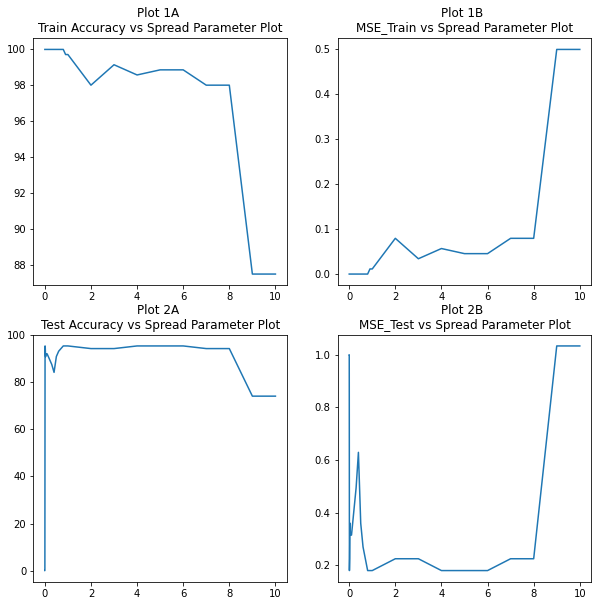

In [31]:
# Plotting
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.title.set_text('Plot 1A \nTrain Accuracy vs Spread Parameter Plot')
ax2.title.set_text('Plot 1B \nMSE_Train vs Spread Parameter Plot')
ax3.title.set_text('Plot 2A \nTest Accuracy vs Spread Parameter Plot')
ax4.title.set_text('Plot 2B \nMSE_Test vs Spread Parameter Plot')
ax1.plot(spread_parameter, accuracy_train)
ax2.plot(spread_parameter, mse_train)
ax3.plot(spread_parameter, accuracy_test)
ax4.plot(spread_parameter, mse_test)

plt.show()

### Part 1 Conclusion

__During Training :__
1. Highhest __accuracy of 100%__ is found for the __spread parameter values from 0.001 to 0.8__ and its respective __MSE is 0.0__
2. Witht __increase in sigma values__ the _accuracy decreases_ which results into _increse of MSE_

__For Testing :__
1. __Accuracy__ goes on increaing and from __sigma = 0.7__ the accruacy is _fairly constat raning from 94.38 % - 95.50 %_
2. Also the MSE ranges from 0.244 and 0.179 for the above range of sigma values
3. Accuracy is 0% and MSE is 1.0 when the sigma value is below 0.1

From the above observation for training and testing we can conclude that for __spread parameters in the range of 0.7 to 0.8__ we get __best results - training accuracy 100% and test accuracy as 95.5%__
<br>
<br>

## Part 2a
### Randomly select 150 centers from the input data.

In [36]:
#Center choice = 1 := Compute RBF with centers as inputs i.e. number of ceneters = 150 random input samples from training set
Q3_part2 = 1

# Set the count of hidden nodes i.e. centers = 150
hidden_nodes = 150

# Initialize all the accuracy and mse values as 0
accur_train, accur_test, MSE_train, MSE_test = 0, 0, 0, 0

# Initialize the arrays for storing Train and Test data's Accuracy and MSE
accuracy_train = []
accuracy_test = []
mse_train = []
mse_test = []


for sigma in spread_parameter:
    training_outcome, predict_out = compute_RBF( train_data, hidden_nodes, train_label, sigma, test_data, Q3_part2)
    training_outcome = np.sign(training_outcome)
    predict_out = np.sign(predict_out)
    
    # Compute Accuracy
    accur_train = get_accuracy(train_label, training_outcome)
    accuracy_train.append(accur_train)
    accur_test = get_accuracy(test_label, predict_out)
    accuracy_test.append(accur_test)

    # Compute MSE
    MSE_train = get_MSE(train_label, training_outcome)
    mse_train.append(MSE_train)
    MSE_test = get_MSE(test_label, predict_out)
    mse_test.append(MSE_test)
    
    print("For spread parameter - {} \n 1. Train Accuracy is: {} and MSE = {}\n 2. Test Accuracy is: {} and MSE = {} \n\n". 
          format(sigma, accur_train, MSE_train, accur_test, MSE_test))

For spread parameter - 0.001 
 1. Train Accuracy is: 32.67045454545455 and MSE = [0.67329545]
 2. Test Accuracy is: 0.0 and MSE = [1.] 


For spread parameter - 0.002 
 1. Train Accuracy is: 34.090909090909086 and MSE = [0.65909091]
 2. Test Accuracy is: 0.0 and MSE = [1.] 


For spread parameter - 0.01 
 1. Train Accuracy is: 90.3409090909091 and MSE = [0.19886364]
 2. Test Accuracy is: 77.52808988764045 and MSE = [0.52808989] 


For spread parameter - 0.02 
 1. Train Accuracy is: 98.29545454545455 and MSE = [0.06818182]
 2. Test Accuracy is: 94.3820224719101 and MSE = [0.2247191] 


For spread parameter - 0.03 
 1. Train Accuracy is: 96.875 and MSE = [0.125]
 2. Test Accuracy is: 91.01123595505618 and MSE = [0.35955056] 


For spread parameter - 0.04 
 1. Train Accuracy is: 97.44318181818183 and MSE = [0.10227273]
 2. Test Accuracy is: 95.50561797752809 and MSE = [0.17977528] 


For spread parameter - 0.05 
 1. Train Accuracy is: 98.01136363636364 and MSE = [0.07954545]
 2. Test Accu

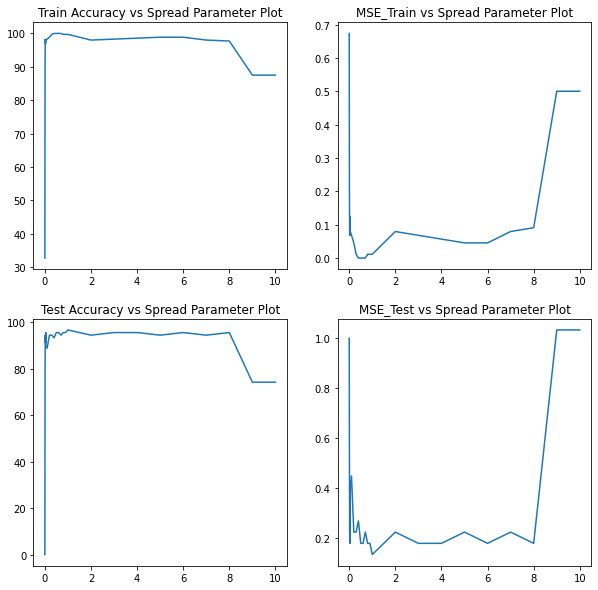

In [37]:
# Plotting
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.title.set_text('Train Accuracy vs Spread Parameter Plot')
ax2.title.set_text('MSE_Train vs Spread Parameter Plot')
ax3.title.set_text('Test Accuracy vs Spread Parameter Plot')
ax4.title.set_text('MSE_Test vs Spread Parameter Plot')
ax1.plot(spread_parameter, accuracy_train)
ax2.plot(spread_parameter, mse_train)
ax3.plot(spread_parameter, accuracy_test)
ax4.plot(spread_parameter, mse_test)
plt.show()

### Part 2a Conclusion

__During Training :__
1. Highhest __accuracy__ of __100%__ is found at __spread parameter value ranging from 0.4 to 0.7__ and its respective __MSE is 0.0__
2. Witht increase in sigma values _from 0.02 to 8_ the accuracy and MSE is above 96% in the range of 97.4% to 100% and _later it starts decresing_
3. For __sigma below 0.01__ the __accuracy__ is low arround __32%__  

__For Testing :__
1. Overall the __Accuracy__ goes on _increaing_ and for 0.02 < sigma < 8 the accruacy is fairly constat raning from 94.38 % - 95.50 %
2. Later after sigma = 8 acuracy goes on decreasing 
3. __Best accuracy__ of __95.50%__ is found for __sigma value in range 0.5 to 0.6__ with MSE = 0.179

From the above observation for training and testing we can conclude that for _spread parameters_ in the _range of 0.02 to 0.8_ we get __best results__. At _sigma 0.5 & 0.6_ we get maximum test _accuracy 95.5%_
<br>
<br>

## Part 2b 
### Use K-Means algorithm to find the centers, select 150 cluster centers

In [41]:
#Center choice = 2 := Compute RBF with centers = cluster centers using k-means clustering 
Q3_part2 = 2

# Set the count of hidden nodes i.e. centers = 150
hidden_nodes = 150

# Initialize all the accuracy and mse values as 0
accur_train, accur_test, MSE_train, MSE_test = 0, 0, 0, 0

# Initialize the arrays for storing Train and Test data's Accuracy and MSE
accuracy_train = []
accuracy_test = []
mse_train =[]
mse_test = []


for sigma in spread_parameter:
    training_outcome, predict_out = compute_RBF( train_data, hidden_nodes, train_label, sigma, test_data, Q3_part2)
    training_outcome = np.sign(training_outcome)
    predict_out = np.sign(predict_out)
    
    # Compute Accuracy
    accur_train = get_accuracy(train_label, training_outcome)
    accuracy_train.append(accur_train)
    accur_test = get_accuracy(test_label, predict_out)
    accuracy_test.append(accur_test)

    # Compute MSE
    MSE_train = get_MSE(train_label, training_outcome)
    mse_train.append(MSE_train)
    MSE_test = get_MSE(test_label, predict_out)
    mse_test.append(MSE_test)
    
    print("For spread parameter - {} \n 1. Train Accuracy is: {} and MSE = {}\n 2. Test Accuracy is: {} and MSE = {} \n\n". 
          format(sigma, accur_train, MSE_train, accur_test, MSE_test))

For spread parameter - 0.001 
 1. Train Accuracy is: 6.8181818181818175 and MSE = [0.93181818]
 2. Test Accuracy is: 0.0 and MSE = [1.] 


For spread parameter - 0.002 
 1. Train Accuracy is: 6.8181818181818175 and MSE = [0.93181818]
 2. Test Accuracy is: 0.0 and MSE = [1.] 


For spread parameter - 0.01 
 1. Train Accuracy is: 61.36363636363637 and MSE = [1.54545455]
 2. Test Accuracy is: 69.66292134831461 and MSE = [1.17977528] 


For spread parameter - 0.02 
 1. Train Accuracy is: 88.63636363636364 and MSE = [0.45454545]
 2. Test Accuracy is: 93.25842696629213 and MSE = [0.26966292] 


For spread parameter - 0.03 
 1. Train Accuracy is: 98.01136363636364 and MSE = [0.07954545]
 2. Test Accuracy is: 93.25842696629213 and MSE = [0.26966292] 


For spread parameter - 0.04 
 1. Train Accuracy is: 98.29545454545455 and MSE = [0.06818182]
 2. Test Accuracy is: 94.3820224719101 and MSE = [0.2247191] 


For spread parameter - 0.05 
 1. Train Accuracy is: 98.29545454545455 and MSE = [0.06818

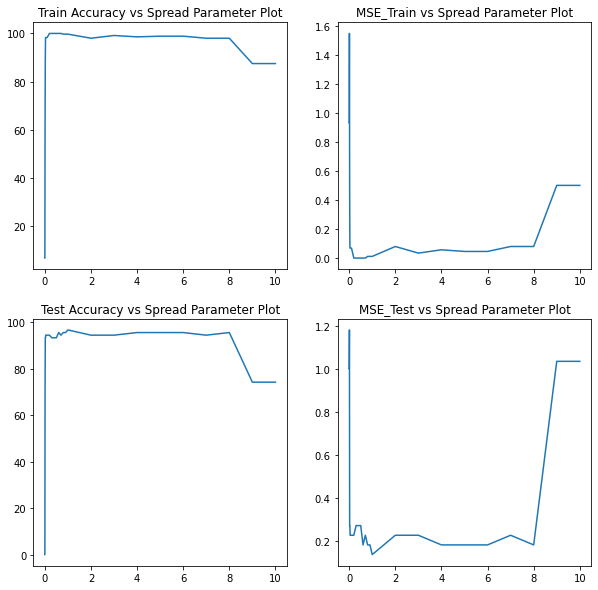

In [42]:
# Plotting
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.title.set_text('Train Accuracy vs Spread Parameter Plot')
ax2.title.set_text('MSE_Train vs Spread Parameter Plot')
ax3.title.set_text('Test Accuracy vs Spread Parameter Plot')
ax4.title.set_text('MSE_Test vs Spread Parameter Plot')
ax1.plot(spread_parameter, accuracy_train)
ax2.plot(spread_parameter, mse_train)
ax3.plot(spread_parameter, accuracy_test)
ax4.plot(spread_parameter, mse_test)
plt.show()

### Part 2b Conclusion

__During Training :__
1. Highhest __accuracy__ of __100%__ is found at __spread parameter value ranging from 0.2 to 0.6__ and its respective __MSE is 0.0__
2. Witht increase in __sigma values from 0.03 to 8__ the accuracy and MSE is fairly constant __ranging from 98% - 100%__ and _later it starts decresing_
3. For __sigma below 0.02__ the __accuracy__ is low arround __6.8%__  

__For Testing :__
1. Overall the __Accuracy__ goes on _increaing_ and for 0.03 < sigma < 8 the accruacy is fairly constat raning from _93.25 % - 96.62 %_
2. Later after sigma = 8 acuracy goes on decreasing 
3. __Best accuracy__ of __96.62%__ is found for __sigma value = 1__

From the above observation for training and testing we can conclude that for spread parameters in the range of 0.02 to 8 we get good results. At __sigma = 1__ we get __maximum test accuracy 96.62%__ with __MSE of 0.134__ and __training accuracy 99.75%__
<br>
<br>